In [100]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_columns', None)

In [101]:
os.chdir('/Users/jed/Documents/JED/Dataiku/drive-download-20250106T224222Z-001')
!ls

census_income_additional_info.pdf census_income_metadata.txt
census_income_learn.csv           census_income_test.csv


In [102]:
#load the train and test datasets into pandas df
train_data=pd.read_csv('census_income_learn.csv', header=None)
test_data=pd.read_csv('census_income_test.csv', header=None)


In [103]:
if len(train_data.columns) == len(test_data.columns):
    print('Both train and test datasets have same no. of columns:', len(test_data.columns))

# There are no column/feature names, will need to add these from metadata.txt file
print('n= ', len(train_data), ' for the training dataset') 
print('n= ', len(test_data), ' for the testing dataset') 

Both train and test datasets have same no. of columns: 42
n=  199523  for the training dataset
n=  99762  for the testing dataset


In [104]:
# need to add column names from metadata.txt file
column_names=['AAGE',
 'ACLSWKR',
 'ADTIND',
 'ADTOCC',
 'AGI',
 'AHGA',
 'AHRSPAY',
 'AHSCOL',
 'AMARITL',
 'AMJIND',
 'AMJOCC',
 'ARACE',
 'AREORGN',
 'ASEX',
 'AUNMEM',
 'AUNTYPE',
 'AWKSTAT',
 'CAPGAIN',
 'CAPLOSS',
 'DIVVAL',
 'FEDTAX',
 'FILESTAT',
 'GRINREG',
 'GRINST',
 'HHDFMX',
 'HHDREL',
 'MARSUPWT',
 'MIGMTR1',
 'MIGMTR2',
 'MIGMTR4',
 'MIGSAME',
 'MIGSUN',
 'NOEMP',
 'PARENT',
 'PEARNVAL',
 'PEFNTVTY',
 'PEMNTVTY',
 'PENATVTY',
 'PRCITSHP',
 'PTOTVAL',
 'SEOTR',
 'TAXINC',
 'VETQVA',
 'VETYN',
 'WKSWORK']

# AGI column is adjusted gross income, which should be removed as it is the target feature
# so should FEDTAX, PERNVAL, PTOTVAL all earning related columns 
# year of survey completion column name is missing from the txt file but is in the df
cols_to_remove=['AGI', 'FEDTAX','PEARNVAL','PTOTVAL','TAXINC', ]

for col in cols_to_remove:
    if col in column_names:
        column_names.remove(col)

column_names = column_names + ['YEAROFSUR']

# # assigned TARGET as the last column
column_names=column_names+['TARGET']

train_data.columns=column_names
test_data.columns=column_names

# # make the target variable binary as this is a binary classification task
train_data['TARGET_bin']=np.where(train_data.TARGET==' 50000+.',1,0)
test_data['TARGET_bin']=np.where(test_data.TARGET==' 50000+.',1,0)

# drop the original target variable
train_data.drop('TARGET', axis=1, inplace=True)
test_data.drop('TARGET', axis=1, inplace=True)
if len(column_names)== len(train_data.columns) == len(test_data.columns):
    print('Column names have been added to the train and test datasets')

Column names have been added to the train and test datasets


## Cleaning Data: removing duplicates, conflicting samples, outlier detection, missing data

In [105]:
# the metadata file describes a number of duplicated data points. Remove before continuing
# first step is to drop the weight column MARSUPWT as this is unique to each sample and will 
# influence the duplicate check

# check for duplicates in the training data

train_data=train_data.drop('MARSUPWT', axis=1)
dupes=train_data[train_data.duplicated(keep='first')]
print('---- Training data ----')
print('no. of duplicated samples = ',len(dupes))


# notice that the no. of duplicated samlpes without keeping the weight values is 10 times greater. By chance, the
# other features were similiar. 

# test data
test_data=test_data.drop('MARSUPWT', axis=1)
dupes=test_data[test_data.duplicated(keep='first')]
print('---- Test data ----')
print('no. of duplicated samples = ',len(dupes))


print('---- Before removing dupes ----')
print('Train: n=', len(train_data), 'Test: n=',  len(test_data))
# save the cleaned datasets
train_data=train_data.drop_duplicates()
test_data=test_data.drop_duplicates()

print('---- After removing dupes ----')
print('Train: n=', len(train_data), 'Test: n=',  len(test_data))

# train_data.to_csv('train_data_dupes_removed.csv', index=False)
# test_data.to_csv('test_data_dupes_removed.csv', index=False)

---- Training data ----
no. of duplicated samples =  46627
---- Test data ----
no. of duplicated samples =  20898
---- Before removing dupes ----
Train: n= 199523 Test: n= 99762
---- After removing dupes ----
Train: n= 152896 Test: n= 78864


In [106]:
# Metadat txt file said there are moore conflicting instances in the dataset.
# checking for samples where all features are the same but the target variable is different
print('---- Training Data ----')
df=train_data.copy()
# Identify conflicting instances
conflicting_instances = df[df.duplicated(subset=df.columns.difference(['TARGET_bin']), keep=False)]
print('no. of conflicting instances =',len(conflicting_instances))

# drop all conflicting instances, not enough information to decide which one to keep
df.drop_duplicates(subset=df.columns.difference(['TARGET_bin']), keep='first', inplace=True)
print('no. of samples after dropping conflicts = ',len(df))

train_data=df.copy()

print('---- Testing Data ----')
df=test_data.copy()
# Identify conflicting instances
conflicting_instances = df[df.duplicated(subset=df.columns.difference(['TARGET_bin']), keep=False)]
print('no. of conflicting instances =',len(conflicting_instances))

# drop all conflicting instances, not enough information to decide which one to keep
df.drop_duplicates(subset=df.columns.difference(['TARGET_bin']), keep='first', inplace=True)
print('no. of samples after dropping conflicts = ',len(df))
test_data=df.copy()

---- Training Data ----
no. of conflicting instances = 178
no. of samples after dropping conflicts =  152807
---- Testing Data ----
no. of conflicting instances = 76
no. of samples after dropping conflicts =  78826


### Outlier detection for continuous variables 
Age, Hours Worked, Weeks Worked

In [107]:
# save high earner and low earner data as sperate datasets to help with EDA
high_earner_data=train_data[train_data['TARGET_bin']==1]
low_earner_data=train_data[train_data['TARGET_bin']==0]

high_earner_data

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,ARACE,AREORGN,ASEX,AUNMEM,AUNTYPE,AWKSTAT,CAPGAIN,CAPLOSS,DIVVAL,FILESTAT,GRINREG,GRINST,HHDFMX,HHDREL,MIGMTR1,MIGMTR2,MIGMTR4,MIGSAME,MIGSUN,NOEMP,PARENT,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,YEAROFSUR,TARGET_bin
57,42,Self-employed-incorporated,37,2,Some college but no degree,0,Not in universe,Married-civilian spouse present,Business and repair services,Executive admin and managerial,White,All other,Male,Not in universe,Not in universe,Full-time schedules,0,0,0,Joint both under 65,Not in universe,Not in universe,Householder,Householder,?,?,?,Not in universe under 1 year old,?,2,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,1
64,47,Private,31,33,12th grade no diploma,0,Not in universe,Married-civilian spouse present,Utilities and sanitary services,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Full-time schedules,0,0,0,Joint both under 65,Not in universe,Not in universe,Householder,Householder,?,?,?,Not in universe under 1 year old,?,6,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,1
68,33,Private,30,33,Associates degree-occup /vocational,0,Not in universe,Separated,Communications,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,2444,10000,Single,Midwest,Indiana,Nonfamily householder,Householder,MSA to MSA,Same county,Same county,No,No,6,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,1
80,58,Self-employed-not incorporated,35,17,Prof school degree (MD DDS DVM LLB JD),0,Not in universe,Married-civilian spouse present,Finance insurance and real estate,Sales,White,All other,Female,Not in universe,Not in universe,Full-time schedules,0,0,0,Joint both under 65,Not in universe,Not in universe,Householder,Householder,?,?,?,Not in universe under 1 year old,?,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,1
88,54,Not in universe,0,0,High school graduate,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Male,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Householder,Householder,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199474,48,Self-employed-not incorporated,35,2,Bachelors degree(BA AB BS),0,Not in universe,Married-spouse absent,Finance insurance and real estate,Executive admin and managerial,Black,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Single,Not in universe,Not in universe,Nonfamily householder,Householder,Nonmover,Nonmover,Nonmover,Yes,Not in universe,1,Not in universe,Jamaica,Cuba,Jamaica,Foreign born- U S citizen by naturalization,0,Not in universe,2,50,94,1
199487,56,Private,31,2,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Utilities and sanitary services,Executive admin and managerial,White,All other,Male,No,Not in universe,Full-time schedules,0,0,0,Joint both under 65,Not in universe,Not in universe,Householder,Householder,?,?,?,Not in universe under 1 year old,?,6,Not in universe,?,?,United-States,Native- Born in the United States,0,Not in universe,2,52,95,1
199499,59,Private,24,2,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Manufacturing-nondurable goods,Executive admin and managerial,White,All other,Female,Not in universe,Not in universe,Full-time s

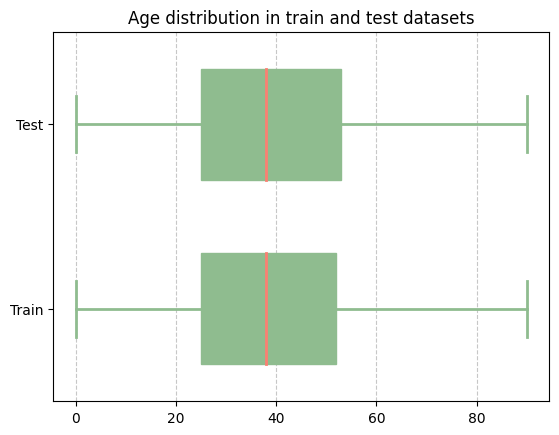

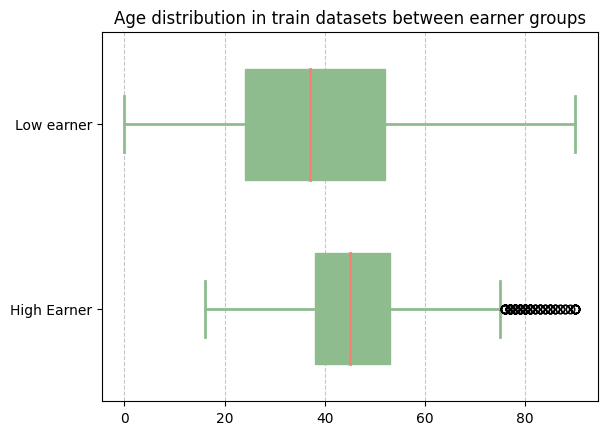

In [108]:
# check for outliers the dataset
feature='AAGE'
train_age=train_data[feature]
test_age=test_data[feature]
boxplot_settings = {
    'patch_artist': True,  # Allows custom coloring
    'boxprops': dict(facecolor='darkseagreen', color='darkseagreen', linewidth=1),
    'whiskerprops': dict(color='darkseagreen', linewidth=2),
    'capprops': dict(color='darkseagreen', linewidth=2),
    'medianprops': dict(color='salmon', linewidth=2),
    'flierprops': dict(marker='o', color='lightseagreen', alpha=0.6),
    'widths': 0.6
}


plt.boxplot([train_age, test_age], labels=['Train', 'Test'], vert=False, **boxplot_settings)
plt.title('Age distribution in train and test datasets')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# check for outliers in the high and low earner datasets
plt.boxplot([high_earner_data[feature], low_earner_data[feature]], labels=['High Earner', 'Low earner'], vert=False, **boxplot_settings)
plt.title('Age distribution in train datasets between earner groups')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# few outliers when looking at labels, I think it's ok
# leave for now, but can be removed using the code below if needed (TukeyIQR)

# label_age=np.array(train_data['AAGE'])
# q3 = np.percentile(label_age, 75)
# q1 = np.percentile(label_age, 25)
# iqr = q3 - q1

# ceiling = q3 + 1.5*iqr
# outliers = label_age[label_age > ceiling]
# print('Outliers: ', outliers)

In [109]:
# check for outliers in the hourspay looking at summary stats and feature boxplots
hrspay_train=train_data['AHRSPAY']
hrspay_test=test_data['AHRSPAY']

hrspay_train.describe()

# we see that the max value is 9999, which is not a valid value for hourly pay
# eyeball unique values 
print(sorted(hrspay_train.unique()))
# so many unique values some are poorbably ccorrect others probably noot

# count the number of samples with 0 hourly pay
hrspay_train.loc[lambda x : x ==0].count()
#141505 samples have 0 as hourly pay, which is not plausile
# we will drop this column as it is not useful for the model
# we will also drop the column from the test dataset
train_data.drop('AHRSPAY', axis=1, inplace=True)
test_data.drop('AHRSPAY', axis=1, inplace=True)

[0, 20, 70, 75, 100, 110, 125, 135, 143, 150, 170, 173, 190, 200, 205, 210, 212, 213, 215, 220, 225, 230, 232, 233, 234, 235, 245, 250, 252, 255, 260, 270, 275, 285, 289, 290, 294, 300, 303, 305, 310, 313, 325, 327, 333, 345, 350, 355, 365, 367, 375, 380, 385, 390, 400, 410, 415, 417, 420, 425, 427, 429, 430, 432, 435, 438, 440, 442, 443, 445, 446, 447, 448, 449, 450, 451, 455, 458, 460, 465, 466, 468, 470, 472, 473, 474, 475, 480, 483, 485, 486, 487, 489, 490, 491, 492, 493, 495, 496, 497, 499, 500, 504, 505, 509, 510, 511, 512, 515, 517, 518, 519, 520, 521, 522, 525, 528, 530, 532, 533, 534, 535, 536, 538, 540, 541, 544, 545, 546, 547, 548, 549, 550, 552, 555, 557, 558, 560, 561, 562, 564, 565, 566, 568, 569, 570, 571, 574, 575, 576, 577, 579, 580, 582, 583, 584, 585, 586, 587, 590, 592, 595, 599, 600, 602, 604, 605, 608, 609, 610, 611, 612, 613, 615, 619, 620, 621, 622, 623, 624, 625, 626, 627, 629, 630, 631, 633, 635, 636, 637, 638, 640, 642, 643, 645, 646, 647, 648, 649, 650, 652,

In [110]:
print(len(train_data['CAPGAIN'].loc[lambda x : x == 15024]))
print(train_data['CAPGAIN'].value_counts()[:10], '\n')
# I am inclined not to trust this column. As it has 390 99999 values. 
# Hard to tell if this should be converted to 0, as it is missing or if it means another error. 
# also random amounts such as 15024, 7688, 7298 seem to be highly frequent. 
# Not sure I can trust this column. 


788
CAPGAIN
0        145433
15024       788
7688        609
7298        582
99999       390
3103        237
5178        207
5013        158
4386        151
3325        121
Name: count, dtype: int64 



In [111]:
print(len(train_data['CAPLOSS'].loc[lambda x : x == 0]))
print(train_data['CAPLOSS'].value_counts()[:10], '\n')
# I am inclined not to trust this column. As it has 390 99999 values. 
# Hard to tell if this should be converted to 0, as it is missing or if it means another error. 


148902
CAPLOSS
0       148902
1902       407
1977       381
1887       364
1602       193
2415       122
1485        95
1848        88
1876        87
1672        85
Name: count, dtype: int64 



In [112]:
print(train_data['DIVVAL'].loc[lambda x : x == 99999].index)
print(train_data['DIVVAL'].value_counts()[:30], '\n')
# these values seem more sensible. only a small number of 99999 values.
# I will keep this column for now.
# explore the 99999 values to see if they relate to the label. 

div9_cases=train_data['DIVVAL'].loc[lambda x : x == 99999].index
train_data.loc[div9_cases]
with9s_removed=high_earner_data.query('DIVVAL < 99999')
with9s_removed['DIVVAL'].value_counts()


Index([   991,   8921,  13733,  14914,  22754,  33995,  35946,  48458,  66668,
        73491,  73833,  75166,  93343,  94558, 102166, 103493, 115161, 124420,
       124965, 132596, 151683, 166660, 168018, 180545, 194878],
      dtype='int64')
DIVVAL
0        131728
100        1144
500        1025
1000        888
200         860
50          825
2000        572
250         553
150         547
300         522
1           472
400         408
1500        380
2500        369
25          360
5000        304
3000        291
600         284
10          253
4000        221
20          213
2           193
10000       181
5           179
125         174
75          169
750         163
30          163
12          146
60          142
Name: count, dtype: int64 



DIVVAL
0       7011
1000     316
500      304
100      290
200      214
        ... 
3800       1
757        1
2905       1
98         1
296        1
Name: count, Length: 607, dtype: int64

In [113]:
# remove CAPGAIN, CAPLOSS and DIVVAL columns, explore keeping DIVVAL if model performance is poor
# i think thee 99999 values are errors, i do not think it is a ceiling valuee. 
# the majority in both igh earners and low earners is 0 in all cols so don't believe it is 
# a highly useful feature

train_data.drop([ 'CAPGAIN', 'CAPLOSS','DIVVAL'], axis=1, inplace=True)
test_data.drop(['CAPGAIN', 'CAPLOSS', 'DIVVAL'], axis=1, inplace=True)


In [114]:
train_data.columns
train_data.dtypes

AAGE           int64
ACLSWKR       object
ADTIND         int64
ADTOCC         int64
AHGA          object
AHSCOL        object
AMARITL       object
AMJIND        object
AMJOCC        object
ARACE         object
AREORGN       object
ASEX          object
AUNMEM        object
AUNTYPE       object
AWKSTAT       object
FILESTAT      object
GRINREG       object
GRINST        object
HHDFMX        object
HHDREL        object
MIGMTR1       object
MIGMTR2       object
MIGMTR4       object
MIGSAME       object
MIGSUN        object
NOEMP          int64
PARENT        object
PEFNTVTY      object
PEMNTVTY      object
PENATVTY      object
PRCITSHP      object
SEOTR          int64
VETQVA        object
VETYN          int64
WKSWORK        int64
YEAROFSUR      int64
TARGET_bin     int64
dtype: object

In [115]:
test_data.columns

Index(['AAGE', 'ACLSWKR', 'ADTIND', 'ADTOCC', 'AHGA', 'AHSCOL', 'AMARITL',
       'AMJIND', 'AMJOCC', 'ARACE', 'AREORGN', 'ASEX', 'AUNMEM', 'AUNTYPE',
       'AWKSTAT', 'FILESTAT', 'GRINREG', 'GRINST', 'HHDFMX', 'HHDREL',
       'MIGMTR1', 'MIGMTR2', 'MIGMTR4', 'MIGSAME', 'MIGSUN', 'NOEMP', 'PARENT',
       'PEFNTVTY', 'PEMNTVTY', 'PENATVTY', 'PRCITSHP', 'SEOTR', 'VETQVA',
       'VETYN', 'WKSWORK', 'YEAROFSUR', 'TARGET_bin'],
      dtype='object')

In [116]:
# NOEMP column is the number of employees, this is an oridinal variable
# 0 = 0
# 1 = <10
# 2 = 10 - 24
# 3 = 25 - 99
# 4 = 100 - 499 
# 5 = 500 - 999 
# 6 = > 1000 


train_data['NOEMP'].value_counts()
# convert to dummy variables
train_data['NOEMP']=train_data['NOEMP'].astype('category')
df = pd.get_dummies(train_data, columns=['NOEMP'], prefix='NOEMP')
df

# test_data['NOEMP']=test_data['NOEMP'].astype('category')


,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHSCOL,AMARITL,AMJIND,AMJOCC,ARACE,AREORGN,ASEX,AUNMEM,AUNTYPE,AWKSTAT,FILESTAT,GRINREG,GRINST,HHDFMX,HHDREL,MIGMTR1,MIGMTR2,MIGMTR4,MIGSAME,MIGSUN,PARENT,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,YEAROFSUR,TARGET_bin,NOEMP_0,NOEMP_1,NOEMP_2,NOEMP_3,NOEMP_4,NOEMP_5,NOEMP_6
0,73,Not in universe,0,0,High school graduate,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,?,?,?,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,0,True,False,False,False,False,False,False
1,58,Self-employed-not incorporated,4,34,Some college but no degree,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,Head of household,South,Arkansas,Householder,Householder,MSA to MSA,Same county,Same county,No,Yes,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0,False,True,False,False,False,False,False
2,18,Not in universe,0,0,10th grade,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,?,?,?,Not in universe under 1 year old,?,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,0,True,False,False,False,False,False,False
3,9,Not in universe,0,0,Children,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0,True,False,False,False,False,False,False
4,10,Not in universe,0,0,Children,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199517,39,Private,43,26,Bachelors degree(BA AB BS),Not in universe,Never married,Education,Adm support including clerical,Other,Mexican-American,Male,No,Not in universe,Full-time schedules,Single,Not in universe,Not in universe,Nonfamily householder,Householder,?,?,?,Not in universe under 1 year old,?,Not in universe,Mexico,Mexico,Mexico,Foreign born- Not a citizen of U S,2,Not in universe,2,52,95,0,False,False,False,False,False,False,True
199518,87,Not in universe,0,0,7th and 8th grade,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,White,All other,Male,Not in universe,Not in universe,Not in labor force,Joint both 65+,Not in universe,Not in universe,Householder,Householder,?,?,?,Not in universe under 1 year old,?,Not in universe,Canada,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,0,True,False,False,False,False,False,False
199519,65,Self-employed-incorporated,37,2,11th grade,Not in universe,Married-civilian spouse pre

In [140]:
from sklearn.preprocessing import OneHotEncoder
df=train_data.copy()

#instantiate OneHotEncoder
encoder = OneHotEncoder(sparse=False) 

#fit and transform the column
encoded = encoder.fit_transform(df[['NOEMP']])

# get the column names
column_names=[]
for i in sorted(df['NOEMP'].unique()):
    column_names.append('NOEMP_{}'.format(i))

encoded_df = pd.DataFrame(encoded, columns=column_names)

# merge the encoded df with the original df
# merged_df = df.merge(encoded_df, left_on=True, right_on=False, how='left')
merged_df = df.join(encoded_df, how='left')

# drop the original column
merged_df.drop('NOEMP', axis=1, inplace=True)

train_data=merged_df.copy()



/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [141]:
train_data

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHSCOL,AMARITL,AMJIND,AMJOCC,ARACE,AREORGN,ASEX,AUNMEM,AUNTYPE,AWKSTAT,FILESTAT,GRINREG,GRINST,HHDFMX,HHDREL,MIGMTR1,MIGMTR2,MIGMTR4,MIGSAME,MIGSUN,PARENT,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,YEAROFSUR,TARGET_bin,NOEMP_0,NOEMP_1,NOEMP_2,NOEMP_3,NOEMP_4,NOEMP_5,NOEMP_6
0,73,Not in universe,0,0,High school graduate,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,?,?,?,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,58,Self-employed-not incorporated,4,34,Some college but no degree,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,Head of household,South,Arkansas,Householder,Householder,MSA to MSA,Same county,Same county,No,Yes,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,18,Not in universe,0,0,10th grade,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,?,?,?,Not in universe under 1 year old,?,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,Not in universe,0,0,Children,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10,Not in universe,0,0,Children,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199517,39,Private,43,26,Bachelors degree(BA AB BS),Not in universe,Never married,Education,Adm support including clerical,Other,Mexican-American,Male,No,Not in universe,Full-time schedules,Single,Not in universe,Not in universe,Nonfamily householder,Householder,?,?,?,Not in universe under 1 year old,?,Not in universe,Mexico,Mexico,Mexico,Foreign born- Not a citizen of U S,2,Not in universe,2,52,95,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199518,87,Not in universe,0,0,7th and 8th grade,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,White,All other,Male,Not in universe,Not in universe,Not in labor force,Joint both 65+,Not in universe,Not in universe,Householder,Householder,?,?,?,Not in universe under 1 year old,?,Not in universe,Canada,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199519,65,Self-employed-incorporated,37,2,11th grade,Not in universe,Married-civilian spouse present,Business and repair services,Executive admin and managerial,White,All other,Male,Not i

In [127]:
df

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHSCOL,AMARITL,AMJIND,AMJOCC,ARACE,AREORGN,ASEX,AUNMEM,AUNTYPE,AWKSTAT,FILESTAT,GRINREG,GRINST,HHDFMX,HHDREL,MIGMTR1,MIGMTR2,MIGMTR4,MIGSAME,MIGSUN,NOEMP,PARENT,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,YEAROFSUR,TARGET_bin
0,73,Not in universe,0,0,High school graduate,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,0
1,58,Self-employed-not incorporated,4,34,Some college but no degree,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,Head of household,South,Arkansas,Householder,Householder,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0
2,18,Not in universe,0,0,10th grade,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,0
3,9,Not in universe,0,0,Children,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
4,10,Not in universe,0,0,Children,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199517,39,Private,43,26,Bachelors degree(BA AB BS),Not in universe,Never married,Education,Adm support including clerical,Other,Mexican-American,Male,No,Not in universe,Full-time schedules,Single,Not in universe,Not in universe,Nonfamily householder,Householder,?,?,?,Not in universe under 1 year old,?,6,Not in universe,Mexico,Mexico,Mexico,Foreign born- Not a citizen of U S,2,Not in universe,2,52,95,0
199518,87,Not in universe,0,0,7th and 8th grade,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,White,All other,Male,Not in universe,Not in universe,Not in labor force,Joint both 65+,Not in universe,Not in universe,Householder,Householder,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Canada,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,0
199519,65,Self-employed-incorporated,37,2,11th grade,Not in universe,Married-civilian spouse present,Business and repair services,Executive admin and managerial,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,Joint one under 65 & one 65+,Not in universe,Not in universe,Householder,Householder,Nonmover,Nonmover,Nonmover,Yes,Not in universe,1,Not in universe,United-States,United-States,United-States,Native- Born